In [2]:
import torch 
import torch.nn as nn
import lightning as L
from glob import glob

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from BalticRiverPrediction.convLSTM import ConvLSTM

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet, LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset
from BalticRiverPrediction.sharedUtilities import read_netcdfs, EnhancedMSELoss, EnhancedMSEMetric, PredictionPlottingCallback

In [3]:
class PredictionData(Dataset):
    def __init__(self, input_size, atmosphericData, runoff, atmosStats, runoffStats, transform=None):

        self.input_size = input_size
        runoffData = runoff.transpose("time", "river")
        
        X = ((atmosphericData - atmosStats[0])/atmosStats[1]).compute()
        y = ((runoffData - runoffStats[0])/runoffStats[1]).compute()
        
        xStacked = X.to_array(dim='variable')
        xStacked = xStacked.transpose("time", "variable", "y", "x")

        assert xStacked.data.ndim == 4
        self.x = torch.tensor(xStacked.data, dtype=torch.float32)
        self.y = torch.tensor(y.data, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x[index:index+(self.input_size)], self.y[index+int(self.input_size)]

    def __len__(self):
        return self.y.shape[0]-(self.input_size)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

def compute_distances_from_point(lat_point, lon_point, grid_lats, grid_lons):
    """
    Compute the distance from a single point to all other points in a grid.
    """
    distances = np.zeros((len(grid_lats), len(grid_lons)))

    for i, lat in enumerate(grid_lats):
        for j, lon in enumerate(grid_lons):
            distances[i, j] = haversine(lat_point, lon_point, lat, lon)
    return distances


In [4]:
datapath="/silor/boergel/paper/runoff_prediction/data"
datapathPP="/silod9/boergel/runoff_prediction_ERA5_downscaled_coupled_model/resampled"

In [5]:
L.seed_everything(123)
torch.set_float32_matmul_precision("medium")

Global seed set to 123


In [6]:
runoff = xr.open_dataset(f"{datapath}/runoff.nc").load()
runoff = runoff.sel(time=slice("1960", "2018"))
runoff = runoff.roflux

DataRain = xr.open_dataset(f"{datapathPP}/rain.nc")
DataRain = DataRain.sel(time=slice("1960", "2018"))
DataRain = DataRain.rain.squeeze()
DataRain = DataRain.drop(["lon","lat"])
DataRain = DataRain.rename({"rlon":"x","rlat":"y"})

DataShumi = xr.open_dataset(f"{datapathPP}/QV.nc")
DataShumi = DataShumi.sel(time=slice("1960", "2018"))
DataShumi = DataShumi.QV.squeeze()
DataShumi = DataShumi.drop(["lon","lat"])
DataShumi = DataShumi.rename({"rlon":"x","rlat":"y"})

DataWindSpeed = xr.open_dataset(f"{datapathPP}/speed.nc")
DataWindSpeed = DataWindSpeed.sel(time=slice("1960", "2018"))
DataWindSpeed = DataWindSpeed.speed.squeeze()
DataWindSpeed = DataWindSpeed.drop(["lon","lat"])
DataWindSpeed = DataWindSpeed.rename({"rlon":"x","rlat":"y"})

DataTemp = xr.open_dataset(f"{datapathPP}/T.nc")
DataTemp = DataTemp.sel(time=slice("1960", "2018"))
DataTemp = DataTemp.T.squeeze()
DataTemp = DataTemp.drop(["lon","lat"])
DataTemp = DataTemp.rename({"rlon":"x","rlat":"y"})

# I think runoff can now be just a placeholder 

assert DataShumi.time[0] == DataRain.time[0] == DataWindSpeed.time[0]
assert len(DataShumi.time) == len(DataRain.time) == len(DataWindSpeed.time)

data = xr.merge([DataRain, DataShumi, DataWindSpeed, DataTemp])

runoffPlaceHolder = xr.Dataset(dict(roflux=(["river", "time"], np.zeros((97, len(data.time))))),
                    coords={
                        "time":data.time,
                        "river":runoff.river
                    })

assert len(runoffPlaceHolder.time) == len(data.time)

In [7]:
nan_check_rain = data['rain'].isnull().any(dim=["x", "y"])
nan_check_shumi = data['QV'].isnull().any(dim=["x", "y"])
nan_check_speed = data['speed'].isnull().any(dim=["x", "y"])

combined_nan_check = nan_check_rain | nan_check_shumi | nan_check_speed

nan_timesteps_indices = np.where(combined_nan_check)[0]

print("Indices of timesteps with NaNs:", data.isel(time=nan_timesteps_indices).time)

Indices of timesteps with NaNs: <xarray.DataArray 'time' (time: 0)>
array([], dtype='datetime64[ns]')
Coordinates:
  * time        (time) datetime64[ns] 
    height_10m  float32 ...
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T


nohup python trainForCoupledModel_more_sensitive.py --modelName TrainCoupledModelMoreSensitive3 --hidden_dim 9 --kernel_size "(7,7)" --num_epochs 400 >& out_3 &

In [1]:
modelParameters = {
    "input_dim": 4,
    "hidden_dim": 9,
    "kernel_size": (7,7),
    "num_layers": 1,
    "batch_first": True,
    "bias": True,
    "return_all_layers": False,
    "dimensions": (222,244),
    "input_size": 30
}

In [8]:
pyTorchBaltNet = BaltNet(modelPar=modelParameters)

In [9]:
LightningBaltNet = LightningModel.load_from_checkpoint(
    # checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive2TopOne-v2.ckpt",
    checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive3TopOne-v2.ckpt"
    learning_rate=1e-3,
    map_location="cpu",
    model=pyTorchBaltNet,
    cosine_t_max=100
)

In [10]:
# Used for the scaling of the NN prediction 
dataDataset = AtmosphericDataset(
    atmosphericData=data.sel(time=slice("1979", "2011")),
    runoff=runoff.sel(time=slice("1979", "2011")),
    input_size=modelParameters["input_size"],
)

# Actual data for prediction
PredictionDataset = PredictionData(
    atmosphericData=data,
    runoff=runoffPlaceHolder.roflux,
    input_size=modelParameters["input_size"],
    atmosStats=dataDataset.atmosphericStats,
    runoffStats=dataDataset.runoffDataStats,
)

In [11]:
predict_dataloader = DataLoader(
    PredictionDataset,
    batch_size=32,
    shuffle=False,
    drop_last=True
    )

In [12]:
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
predictions = trainer.predict(LightningBaltNet, dataloaders=predict_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [14]:
concatenated_predictions = torch.cat(predictions, dim=0) # concat in time
rescaledRunoffData = concatenated_predictions*dataDataset.runoffDataStats[1].data+dataDataset.runoffDataStats[0].data

In [15]:
rescaledRunoffDataDataset = xr.DataArray(
    data = rescaledRunoffData.data,
    coords={
        "time": runoffPlaceHolder.time[modelParameters["input_size"]:],
        "river": runoffPlaceHolder.river
    }
)


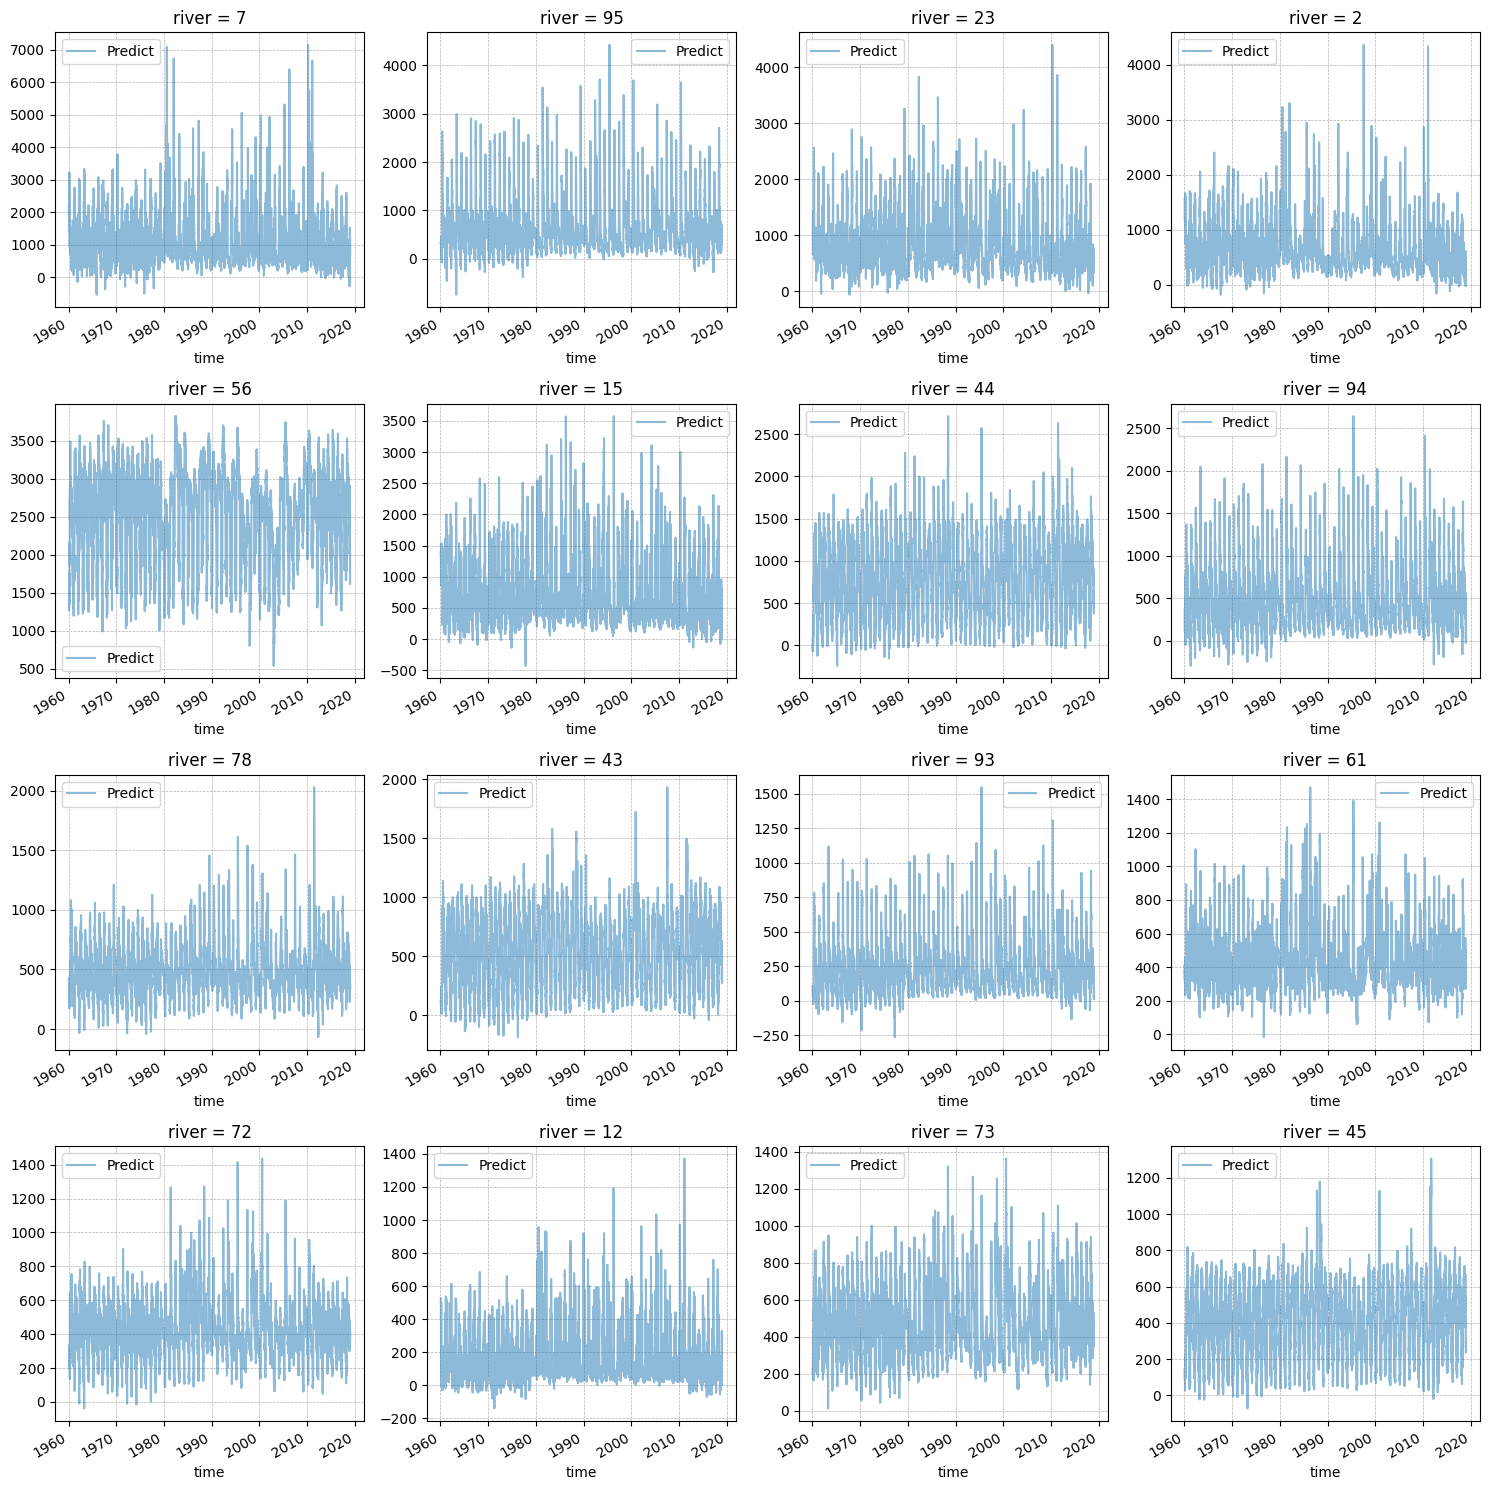

In [16]:
total_runoff_per_river = rescaledRunoffDataDataset.max(dim="time")
largest_rivers_indices = np.argsort(-total_runoff_per_river.data)[:16]

f, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axs.ravel()):
    river_index = largest_rivers_indices[i]
    ax.set_title(f"River {river_index + 1}")

    # Plotting data for the specific river index
    rescaledRunoffDataDataset.isel(river=river_index).plot(ax=ax, label="Predict", alpha=.5)
    
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()


We need to start by analyzing the MOM 5.1 dry/wet [0,1] grid to find the correct domain for the rivers.

In [17]:
gridWetMask = xr.open_dataset("/silor/boergel/paper/MOM-Projection-runs/data/grid_spec.nc")

In [18]:
lonPoints = gridWetMask["grid_x_T"]
latPoints = gridWetMask["grid_y_T"]

The runoff in MOM is stored as a 3D-file (t, y, x) where river runoff is set to zero if no river is located at the point of reference.

In [19]:
emptyRunoff = xr.Dataset(
        data_vars={
            "roflux": (["time", "lat", "lon"], np.zeros((
                        len(rescaledRunoffDataDataset.time),
                        len(latPoints),
                        len(lonPoints))))
            },
        coords={
                    "time":rescaledRunoffDataDataset.time.data,
                    "lat":latPoints.data,
                    "lon":lonPoints.data
                }
)

In [20]:
emptyRunoff["wet"] = (["lat", "lon"], gridWetMask.wet.data)

In [21]:
# We will iterate over all E-HYPE rivers since they stored the corresponding lon/lat position.

allRivers = sorted(glob(f"{datapath}/runoffData/combined_fastriver_*.nc"))

for i, singleRiver in enumerate(allRivers):

    riverData = xr.open_dataset(singleRiver)
    lonRiver = riverData.roflux.lon
    latRiver = riverData.roflux.lat

    # Select the nearest river and map the predicted river runoff
    nearest_data = emptyRunoff.sel(lon=lonRiver, lat=latRiver, method="nearest")
    emptyRunoff["roflux"].loc[dict(lon=nearest_data.lon, lat=nearest_data.lat)] = rescaledRunoffDataDataset.isel(river=i).data

In [22]:
# Calculate mean, river locations will be non-zero
mean_roflux = emptyRunoff['roflux'].mean(dim='time')

# get indices of rivers
nonzero_mean_locs = mean_roflux > 0
nonzero_mean_indices = np.where(nonzero_mean_locs)

In [23]:
# Now we look if the mapping was onto grid point or not.
wet_values_at_nonzero_mean = emptyRunoff['wet'].data[nonzero_mean_indices[0], nonzero_mean_indices[1]]
indices_needing_relocation = np.where(wet_values_at_nonzero_mean == 0)

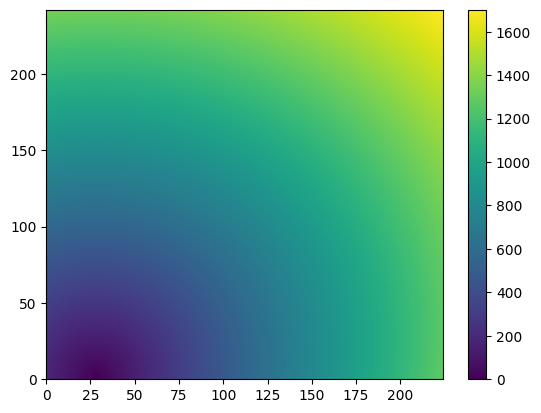

In [24]:
# With compute_distances_from_point we calculate the spatial distance of a point from the current river locations

grid_lats = emptyRunoff.lat.values 
grid_lons = emptyRunoff.lon.values

distance_matrix = compute_distances_from_point(
    grid_lats[nonzero_mean_indices[0][0]],
    grid_lons[nonzero_mean_indices[1][0]],
    grid_lats,
    grid_lons
)

plt.pcolor(distance_matrix)
plt.colorbar()

In [25]:
CorrectedRunoff = emptyRunoff.copy()

In [26]:
# We now iterate over all rivers that are currently not on a wet grid point

for index in indices_needing_relocation[0]:
    
    lat_idx, lon_idx = nonzero_mean_indices[0][index], nonzero_mean_indices[1][index]
 
    distance_matrix = compute_distances_from_point(
        grid_lats[lat_idx],
        grid_lons[lon_idx],
        grid_lats,
        grid_lons)

    # Only consider points that are on the wet grid
    distance_matrix[np.where(CorrectedRunoff['wet'].data == 0)] = np.inf
    lat_shifted, lon_shifted = np.unravel_index(distance_matrix.argmin(), distance_matrix.shape)
    
    # Copy data to the nearest wet grid point. Overwrite all location with zeros.
    CorrectedRunoff["roflux"].isel(lat=lat_shifted, lon=lon_shifted).data[:] = CorrectedRunoff["roflux"].isel(lat=lat_idx, lon=lon_idx).data[:]
    CorrectedRunoff["roflux"].isel(lat=lat_idx, lon=lon_idx).data[:] = 0

In [27]:
mean_roflux = CorrectedRunoff['roflux'].mean(dim='time')
nonzero_mean_locs = mean_roflux > 0
nonzero_mean_indices = np.where(nonzero_mean_locs)
wet_values_at_nonzero_mean = CorrectedRunoff['wet'].data[nonzero_mean_indices[0],nonzero_mean_indices[1]]
indices_needing_relocation = np.where(wet_values_at_nonzero_mean == 0)
indices_needing_relocation

(array([], dtype=int64),)

In [28]:
area_t = gridWetMask['area_T'][:]
CorrectedRunoff['roflux'][:] = CorrectedRunoff['roflux'].data/area_t.data*1000

In [29]:
CorrectedRunoff.lon.attrs["long_name"] = "longitude"
CorrectedRunoff.lon.attrs['units'] = "degrees_east"

CorrectedRunoff.lat.attrs["long_name"] = "latitude"
CorrectedRunoff.lat.attrs["units"] = "degrees_north"

CorrectedRunoff = CorrectedRunoff.rename({"roflux":"runoff"})

CorrectedRunoff.runoff.attrs["long_name"] = "River Runoff"
CorrectedRunoff.runoff.attrs["units"] = ""

CorrectedRunoff.attrs["description"] = 'Runoff dataset for predicted with ConvLSTM. River locations are interpolated onto MOM 3nm grid. Units are changed by dividing by area_t (grid cell size) and 1000 (for density).'

CorrectedRunoff.attrs["author"] = "Florian Boergel, florian.boergel@io-warnemuende.de"

CorrectedRunoff.to_netcdf("/fast/boergel/paper/runoff_prediction/convLSTM_runoff.nc")
CorrectedRunoff.close()